<a href="https://colab.research.google.com/github/stefan-stein/NLP_with_TF_2.0/blob/master/NLP_with_TF_2_0_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These are my notes for the first part of the "Natural Language Processing with Tensorflow  2 - Beginner's course" that can be found [here](https://www.youtube.com/watch?v=B2q5cRJvqI8). This course consists of three parts which in turn are based on the corresponding official tensorflow tutorials. The first part deals with word embeddings and is based on [this](https://www.tensorflow.org/tutorials/text/word_embeddings) tutorial.

# Word Embeddings

Colab currently still imports tensorflow 1.x by default, so we need to select version 2.x explicitly.

In [1]:
import io
import matplotlib.pyplot as plt
# Make sure we are importing TF 2.x
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

TensorFlow 2.x selected.


In [2]:
print(tf.__version__)

2.1.0


We are going to analyse the IMDB moview review dataset. From the TensorFlow datasets [website](https://www.tensorflow.org/datasets/catalog/imdb_reviews#imdb_reviewssubwords8k):
> Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.

We import the 'subwords8k' version, which is to say we use a vocabulary size of 8k. The other options passed to the `tfds.load()` function are `as.supervised=True`, meaning we import the data with corresponding binary lable (good review/ bad review).

After downloading the data, we create training and testing batches.
Reviews are not all of the same length. Hence, we find the longest review and add padding to all other reviews to make all reviews of the same lenght. Using `None` in `padded_shapes` means that we are padding up to the maximum review length. See documentation of [`padded_batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch).

We wrap all of that into one clean function.

In [0]:
def get_batch_data():
  (train_data, test_data), info = tfds.load('imdb_reviews/subwords8k',
                                          split = (tfds.Split.TRAIN, tfds.Split.TEST),
                                          with_info=True, as_supervised=True)
  encoder = info.features['text'].encoder
  padded_shapes = ([None], ())
  # shuffle data, use batch size of 10
  train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)
  test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)

  return train_batches, test_batches, encoder

Next, we build a function to create our model. It takes two arguments, an encoder and the dimension of the latent embedding space, which by default we set to `16`. As is typical with Keras, it is a sequential model. Our first layer is an embedding layer, using the `vocab_size` attribute of the `encoder` object defined above. The last layer is a dense layer with output dimension 1 and `'sigmoid'` activation function, i.e. it gives out a number between zero and one corresponding to the probability that the review is positive.

In [0]:
def get_model(encoder, embedding_dim=16):
  model = keras.Sequential([
                    layers.Embedding(encoder.vocab_size, embedding_dim, mask_zero=True),
                    layers.GlobalAveragePooling1D(),
                    layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

Next, we create a function to plot the training progress over time. It takes the training `history` of our model as argument and returns a plot showing the training loss and validation loss by epoch.

In [0]:
def plot_history(history):
  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(12,9))
  # blue dots
  plt.plot(epochs, acc, 'bo', label = 'Training acc')
  # just blue line
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.ylim((0.5,1))
  plt.show()

Finally, we want to have a function that allows us to download the learned embeddings, which we then can visualize using the [embedding projector](https://projector.tensorflow.org/).

In [0]:
def retrieve_embeddings(model, encoder):
  out_vectors = io.open('vecs.tsv', 'w', encoding='utf-8')
  out_metadata = io.open('meta.tsv', 'w', encoding='utf-8')
  # 0th layer is the embedding layer and we retrieve its weights,
  # get_weights returns list of length one, so use [0] to get actual content
  weights = model.layers[0].get_weights()[0]

  for num, word in enumerate(encoder.subwords):
    # we take +1 here, because 0 is not a word and only used for padding
    vec = weights[num+1]
    out_metadata.write(word + '\n')
    out_vectors.write('\t'.join([str(x) for x in vec]) + '\n')
  out_vectors.close()
  out_metadata.close()

With all of this set up, let's give it a try. Get the data first.

In [0]:
train_batches, test_batches, encoder = get_batch_data()

Let's take a look what we actually just downloaded.

In [8]:
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [9]:
# number of words in our vocabulary
print(encoder.vocab_size)

8185


Alright, vocabulary size is around 8k, as it should be. Let's build the actual model next.

In [0]:
model = get_model(encoder)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


This worked, too. So all that's left to do now is actual training.

In [12]:
history = model.fit(train_batches, epochs=10, validation_data=test_batches,
                    validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 23s 9ms/step - loss: 0.5280 - accuracy: 0.7948 - val_loss: 0.4513 - val_accuracy: 0.8000
Epoch 2/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.3141 - accuracy: 0.8858 - val_loss: 0.3385 - val_accuracy: 0.8600
Epoch 3/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2453 - accuracy: 0.9099 - val_loss: 0.3076 - val_accuracy: 0.8550
Epoch 4/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2085 - accuracy: 0.9234 - val_loss: 0.2806 - val_accuracy: 0.9100
Epoch 5/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1831 - accuracy: 0.9342 - val_loss: 0.3341 - val_accuracy: 0.8900
Epoch 6/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1642 - accuracy: 0.9411 - val_loss: 0.2983 - val_accuracy: 0.9000
Epoch 7/10
2500/2500 [==============================] - 18s 7ms/step - loss: 0.1486 - accuracy: 0.9476 - val_loss: 0.3744 - val_ac

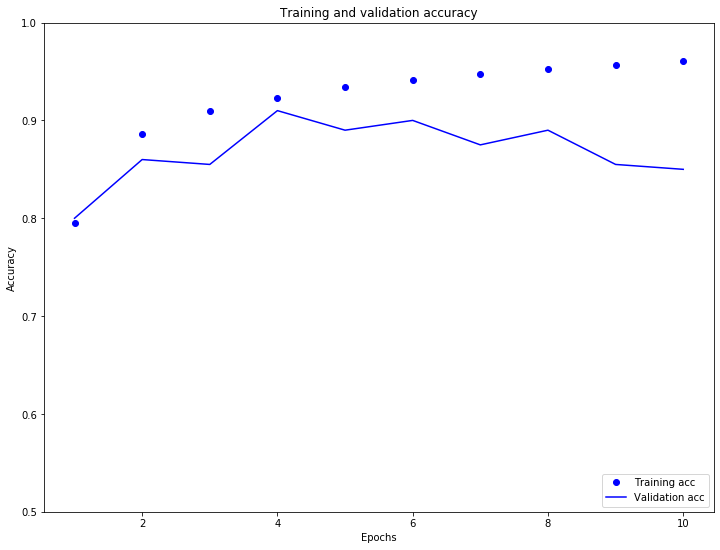

In [13]:
plot_history(history)

Training accuracy went up over time as is to be expected, while validation does not look too great, to be honest. But this might be expected for such a simple model. We can see that we are overfitting to the data after epoch 8.

Finally, let's download the learned embeddings.

In [0]:
retrieve_embeddings(model, encoder)

You can go to the [embedding projector](https://projector.tensorflow.org/) to visualize the downloaded word embeddings. Check out the 'Word_embeddings_superb.png' in this Github repo to see what this might look like.